# Text Processing with spaCy

In [444]:
import gzip
import pickle
import numpy as np
from configparser import ConfigParser
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import re
import string
punctuations = string.punctuation
import warnings

# spaCy
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import spacy
    nlp = spacy.load('en')

# gensim
from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

from sklearn.cluster import KMeans
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.preprocessing import Normalizer

# logging for gensim (set to INFO)
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Read in tweet data from Mongodb

In [222]:
config = ConfigParser()
config.read('../config.ini')

client = MongoClient("mongodb://{}:{}@{}/{}".format(
                        config.get('MongoConfig', 'user'),
                        config.get('MongoConfig', 'password'),
                        config.get('MongoConfig', 'host'),
                        config.get('MongoConfig', 'db')
                        ), int(config.get('MongoConfig', 'port')))

In [223]:
db = client.twitter_db

In [224]:
db.collection_names()

['Init', 'tweets', 'favorited_tweets']

In [225]:
db.favorited_tweets.count()

1113805

In [234]:
cursor = db.favorited_tweets.find({}).limit(10000)

In [235]:
tweet_data = [document  for document in cursor]

In [236]:
rawtext = [tweet['full_text'] for tweet in tweet_data]

rawtext[:10]

["100% correct. Congress must still act. This Administration will end DACA and has the authority to do so -- it just didn't do it legally. Yet. https://t.co/HxiDhioeMY",
 '#DACA renewals continue. Sessions &amp; DOJ overreached to skip Courts of Appeal. Congress must still act. #CleanDreamActNow #DreamActNow #Dreamers https://t.co/jUrwbqNU6p',
 'More courageous young people leading! #DreamActNow #CleanDreamAct https://t.co/WT0OuZbOVR',
 "Philando Castile's mom slams NRA chief LaPierre as a hypocrite - NY Daily News https://t.co/RLpLAw4VzX",
 'From one of the teen activists from #Parkland #BanAssaultWeapons #BoycottNRA https://t.co/RjnUwmCypF',
 '&lt;em&gt;Black Panther&lt;/em&gt; Actor Bambadjan Bamba Is a Dreamer https://t.co/r3CFWoVAAR\n#DreamActNow',
 'As an immigration attorney for 20 years - let\'s be clear: Melania\'s parents got greencards through Melania\'s family petition once she became US Citizen. Pres Trump\'s proposals and critique of "chain migration" would close the door

## Normalize Text

#### Clean, Tokenize and Vectorize (maybe Stem, Lemmatize)

In [348]:
def clean_tweet(tweet):
    """
    Function to remove urls, numbers and punctuation, and make lowercase
    """
    no_url = re.sub(r'http\S+', '', tweet)
    clean = re.sub(r'[^\w\s]', '', no_url)
    
    result = ''.join([str(i).replace('\n', ' ').lower() for i in clean if not i.isdigit()])

    return result

In [349]:
cleantext = [clean_tweet(i) for i in rawtext]
print(rawtext[1], '\n')
print(cleantext[1])

#DACA renewals continue. Sessions &amp; DOJ overreached to skip Courts of Appeal. Congress must still act. #CleanDreamActNow #DreamActNow #Dreamers https://t.co/jUrwbqNU6p 

daca renewals continue sessions amp doj overreached to skip courts of appeal congress must still act cleandreamactnow dreamactnow dreamers 


In [417]:
def spacy_tokenizer(tweet):
    """
    Utility function to remove stopwords, ignore pronouns and tokenize words before vectorizing
    """
    doc = nlp(tweet)
    tokens = [token.orth_ for token in doc if 
              (token.orth_ not in stopwords and token.pos_ in ['NOUN', 'PROPN', 'VERB', 'ADJ'])]
            
    return tokens

In [419]:
print(cleantext[0])

tokens_test = spacy_tokenizer(cleantext[0])
tokens_test

 correct congress must still act this administration will end daca and has the authority to do so  it just didnt do it legally yet 


['correct',
 'congress',
 'act',
 'administration',
 'end',
 'daca',
 'authority',
 'did']

In [399]:
#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, 
                             ngram_range=(1,1))

In [400]:
vectorizer.fit(cleantext)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function spacy_tokenizer at 0x11fe446a8>, use_idf=True,
        vocabulary=None)

In [401]:
counts = vectorizer.transform(cleantext).transpose()

In [402]:
np.shape(counts)

(15661, 10000)

In [403]:
pd.DataFrame(counts.toarray(), vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a_clay_cahoon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aapi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aapiequalpay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [404]:
corpus = matutils.Sparse2Corpus(counts)

In [405]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [406]:
len(id2word)

15661

In [407]:
with open('../data/processed/word_features.pkl', 'wb') as wf:
    pickle.dump(id2word, wf)

## Dimensionality Reduction and Topic Modeling

### Try LDA to visualizae topic mappings using pyLDAvis
http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=0.51&term=

In [408]:
lda = models.LdaModel(corpus=corpus, num_topics=20, id2word=id2word, passes=5)

2018-03-01 16:50:27,865 : INFO : using symmetric alpha at 0.05
2018-03-01 16:50:27,868 : INFO : using symmetric eta at 0.05
2018-03-01 16:50:27,871 : INFO : using serial LDA version on this node
2018-03-01 16:50:29,381 : INFO : running online (multi-pass) LDA training, 20 topics, 5 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 10000 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-01 16:50:29,388 : INFO : PROGRESS: pass 0, at document #2000/10000
2018-03-01 16:50:30,392 : INFO : merging changes from 2000 documents into a model of 10000 documents
2018-03-01 16:50:30,494 : INFO : topic #17 (0.050): 0.009*"tv" + 0.005*"man" + 0.005*"flood" + 0.004*"trump" + 0.004*"warning" + 0.004*"county" + 0.003*"delta" + 0.003*"texas" + 0.003*"school" + 0.003*"says"
2018-03-01 16:50:30,495 : INFO : topic #2 (0.050): 0.007*"tv" + 0.006*"alert" + 0.005*"weather" + 0.004*"florida" + 0.004*"shooting" + 0.00

In [409]:
lda.print_topics()

2018-03-01 16:50:56,568 : INFO : topic #0 (0.050): 0.007*"stop" + 0.007*"ll" + 0.006*"heres" + 0.006*"marijuana" + 0.006*"country" + 0.005*"kushner" + 0.005*"central" + 0.005*"weapons" + 0.005*"gets" + 0.005*"cyrustoulabi"
2018-03-01 16:50:56,570 : INFO : topic #1 (0.050): 0.012*"thank" + 0.010*"facts" + 0.007*"lot" + 0.006*"talking" + 0.006*"power" + 0.005*"better" + 0.005*"action" + 0.005*"pay" + 0.004*"great" + 0.004*"conspiracy"
2018-03-01 16:50:56,572 : INFO : topic #2 (0.050): 0.008*"telemundopr" + 0.008*"america" + 0.008*"gracias" + 0.006*"corrupt" + 0.005*"thatisabot" + 0.005*"smith" + 0.005*"people" + 0.005*"heart" + 0.004*"ironstowe" + 0.004*"attack"
2018-03-01 16:50:56,573 : INFO : topic #3 (0.050): 0.007*"nra" + 0.007*"let" + 0.006*"awesome" + 0.006*"know" + 0.006*"think" + 0.006*"hockey" + 0.006*"support" + 0.006*"missing" + 0.005*"fedex" + 0.005*"way"
2018-03-01 16:50:56,575 : INFO : topic #4 (0.050): 0.010*"cpac" + 0.008*"love" + 0.006*"fascists" + 0.006*"hate" + 0.005*"

[(0,
  '0.007*"stop" + 0.007*"ll" + 0.006*"heres" + 0.006*"marijuana" + 0.006*"country" + 0.005*"kushner" + 0.005*"central" + 0.005*"weapons" + 0.005*"gets" + 0.005*"cyrustoulabi"'),
 (1,
  '0.012*"thank" + 0.010*"facts" + 0.007*"lot" + 0.006*"talking" + 0.006*"power" + 0.005*"better" + 0.005*"action" + 0.005*"pay" + 0.004*"great" + 0.004*"conspiracy"'),
 (2,
  '0.008*"telemundopr" + 0.008*"america" + 0.008*"gracias" + 0.006*"corrupt" + 0.005*"thatisabot" + 0.005*"smith" + 0.005*"people" + 0.005*"heart" + 0.004*"ironstowe" + 0.004*"attack"'),
 (3,
  '0.007*"nra" + 0.007*"let" + 0.006*"awesome" + 0.006*"know" + 0.006*"think" + 0.006*"hockey" + 0.006*"support" + 0.006*"missing" + 0.005*"fedex" + 0.005*"way"'),
 (4,
  '0.010*"cpac" + 0.008*"love" + 0.006*"fascists" + 0.006*"hate" + 0.005*"irisrimon" + 0.005*"county" + 0.005*"daddy" + 0.004*"unions" + 0.004*"flood" + 0.004*"proud"'),
 (5,
  '0.011*"irdotnet" + 0.011*"police" + 0.010*"yearold" + 0.009*"man" + 0.009*"hell" + 0.007*"connectin

In [410]:
def find_topic_dist(tweet_index):
    print(rawtext[tweet_index], '\n')
    print(lda[corpus[tweet_index]])
    topic = max(lda[corpus[tweet_index]], key=lambda x:x[1])
    
    return topic

In [411]:
find_topic_dist(1000)

WEATHER ALERT: Areal Flood Watch for Perry, Morgan, Athens, Washington, Jackson and Vinton County until 1:00pm Sunday. https://t.co/rER0n11LOI 

[(0, 0.010975678), (1, 0.010975678), (2, 0.010975678), (3, 0.010975678), (4, 0.3476652), (5, 0.32406038), (6, 0.010975678), (7, 0.010975678), (8, 0.010975678), (9, 0.010975678), (10, 0.010975678), (11, 0.010975678), (12, 0.010975678), (13, 0.010975678), (14, 0.010975679), (15, 0.010975678), (16, 0.14168784), (17, 0.010975678), (18, 0.010975678), (19, 0.010975678)]


(4, 0.3473345)

In [412]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [413]:
tokens = [i[0] for i in vectorizer.vocabulary_.items()]
dictionary = corpora.Dictionary(np.array(tokens).reshape(-1, 1))
len(dictionary)

2018-03-01 16:50:56,649 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-01 16:50:56,724 : INFO : adding document #10000 to Dictionary(10000 unique tokens: ['correct', 'congress', 'act', 'administration', 'end']...)
2018-03-01 16:50:56,764 : INFO : built Dictionary(15661 unique tokens: ['correct', 'congress', 'act', 'administration', 'end']...) from 15661 documents (total 15661 corpus positions)


15661

In [414]:
data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

In [438]:
pyLDAvis.show(data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [01/Mar/2018 17:12:01] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Mar/2018 17:12:01] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [01/Mar/2018 17:12:01] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Mar/2018 17:12:01] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


## Try LSA with three dimensions for interpretability

In [441]:
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

2018-03-01 17:21:10,576 : INFO : using symmetric alpha at 0.3333333333333333
2018-03-01 17:21:10,580 : INFO : using symmetric eta at 0.3333333333333333
2018-03-01 17:21:10,585 : INFO : using serial LDA version on this node
2018-03-01 17:21:10,825 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 10000 documents, updating model once every 2000 documents, evaluating perplexity every 10000 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-01 17:21:10,834 : INFO : PROGRESS: pass 0, at document #2000/10000
2018-03-01 17:21:13,672 : INFO : merging changes from 2000 documents into a model of 10000 documents
2018-03-01 17:21:13,703 : INFO : topic #0 (0.333): 0.006*"tv" + 0.004*"county" + 0.004*"flood" + 0.003*"winter" + 0.003*"warning" + 0.003*"olympics" + 0.003*"pm" + 0.003*"man" + 0.002*"weather" + 0.002*"new"
2018-03-01 17:21:13,705 : INFO : topic #1 (0.333): 0.008*"tv" + 0.004*"trump" + 0.004*"olympics" + 0.004*"youtub

In [442]:
lda.print_topics()

2018-03-01 17:22:27,054 : INFO : topic #0 (0.333): 0.003*"krassenstein" + 0.003*"realdonaldtrump" + 0.003*"cnnpolitics" + 0.003*"edkrassen" + 0.002*"nra" + 0.002*"kmasports" + 0.002*"s" + 0.002*"telemundopr" + 0.002*"irdotnet" + 0.002*"dwyer"
2018-03-01 17:22:27,057 : INFO : topic #1 (0.333): 0.007*"trump" + 0.004*"thehill" + 0.004*"s" + 0.003*"trumps" + 0.003*"safetypindaily" + 0.003*"president" + 0.002*"people" + 0.002*"says" + 0.002*"nra" + 0.002*"amp"
2018-03-01 17:22:27,059 : INFO : topic #2 (0.333): 0.005*"school" + 0.004*"police" + 0.003*"connectingyou" + 0.003*"man" + 0.003*"shooting" + 0.002*"county" + 0.002*"yearold" + 0.002*"youtube" + 0.002*"live" + 0.002*"high"


[(0,
  '0.003*"krassenstein" + 0.003*"realdonaldtrump" + 0.003*"cnnpolitics" + 0.003*"edkrassen" + 0.002*"nra" + 0.002*"kmasports" + 0.002*"s" + 0.002*"telemundopr" + 0.002*"irdotnet" + 0.002*"dwyer"'),
 (1,
  '0.007*"trump" + 0.004*"thehill" + 0.004*"s" + 0.003*"trumps" + 0.003*"safetypindaily" + 0.003*"president" + 0.002*"people" + 0.002*"says" + 0.002*"nra" + 0.002*"amp"'),
 (2,
  '0.005*"school" + 0.004*"police" + 0.003*"connectingyou" + 0.003*"man" + 0.003*"shooting" + 0.002*"county" + 0.002*"yearold" + 0.002*"youtube" + 0.002*"live" + 0.002*"high"')]

In [445]:
topic_distributions = [lda[i] for i in corpus]

In [449]:
topic_a = [i[0][1] for i in topic_distributions]
topic_b = [i[1][1] for i in topic_distributions]
topic_c = [i[2][1] for i in topic_distributions]

In [451]:
topic_list = [[a, b, c] for (a, b, c) in zip(topic_a, topic_b, topic_c)]

In [453]:
topic_list[:10]

[[0.12417443, 0.5367311, 0.33909443],
 [0.0751728, 0.8151964, 0.10963078],
 [0.104571864, 0.105776526, 0.7896516],
 [0.15567283, 0.17918168, 0.66514546],
 [0.41244277, 0.12636827, 0.46118894],
 [0.73849607, 0.16247146, 0.09903249],
 [0.07420056, 0.72991043, 0.19588897],
 [0.17152429, 0.65696836, 0.17150733],
 [0.7068675, 0.1608255, 0.13230692],
 [0.33333334, 0.33333334, 0.33333334]]

In [454]:
pca = PCA(n_components=2)
pca.fit(topic_list)
pcafeatures_train = pca.transform(topic_list)

In [462]:
x = [i[0] for i in pcafeatures_train]
y = [i[1] for i in pcafeatures_train]

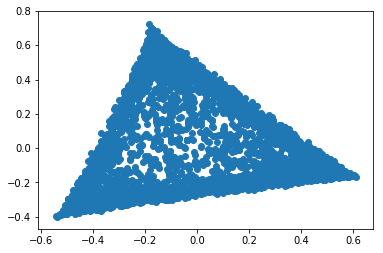

In [463]:
plt.scatter(x, y)

In [456]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

In [ ]:
plot_PCA_2D(pcafeatures_train, target_names=digits.target_names)

In [427]:
import matplotlib.pyplot as plt

% matplotlib inline 

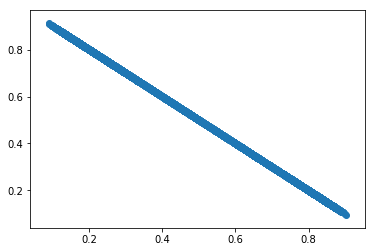

In [436]:
plt.scatter(topic_x, topic_y)

## Try LSA

In [251]:
lsa = TruncatedSVD(10, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(counts)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)


In [252]:
lsa.explained_variance_ratio_


array([0.00500755, 0.00360424, 0.0033963 , 0.00306783, 0.00299824,
       0.00250967, 0.00248485, 0.00231181, 0.00225991, 0.00218691])

In [253]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [254]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
apprenticeships, detention, cole, dwindling, developer, northbound, nonunion, nokias, attend, conscience

Topic  1
northbound, nonunion, nokias, encourages, endured, billy, blade, ems, bitcoins, conor

Topic  2
ave, automated, avenger, automatic, authorities, auctioned, aurora, awaiting, audition, atlantas

Topic  3
djb, dna, complicated, divorce, dm, flavors, cut, btwtrumporangutan, brook, cybercrime

Topic  4
cdwi, caught, audience, explainer, castle, celebration, exports, extortion, attempt, birthed

Topic  5
chimera, christian, circus, farmworker, fan, city, christopher, chocoharveymilk, analogies, dow

Topic  6
dog, educating, dogg, arraignments, compassion, coffees, deport, appeals, depositing, dummies

Topic  7
bruiser_ahdmascot, bombs, bot, bosses, bookstagram, border, boxes, crystal, crushed, boycotnra

Topic  8
bookstagram, boycotnra, bosses, crystal, border, boxes, crushed, bot, dystopian, colors

Topic  9
bennyv, emmagonzales, crewcrew, employed, embarrassment, be

## Try PCA